In [4]:
## import packages
import os, cv2
import numpy as np 
import pandas as pd 
import math
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import PIL
import PIL.Image

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

import tensorflow as tf
from tensorflow import math
from tensorflow.keras import layers
from keras.models import Sequential, Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.applications import mobilenet
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from keras import backend as K
import sys
import math
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from skimage.exposure import equalize_hist
import cv2
import numpy as np
!pip install pydicom
from PIL import Image
IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNEL = 7
num_classes = 7 
import pydicom
e = 2.7182

In [5]:
# Import functions from Kaggle example code:

# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(16,16))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        # plt.xticks([]); 
        # plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        
        if type(image) == str:
            image = mpimg.imread(image)
        
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)    
    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x


# See https://stackoverflow.com/questions/43884463/how-to-convert-rgb-image-to-one-hot-encoded-3d-array-based-on-color-using-numpy
def rgb_to_onehot(rgb_arr, color_dict):
    num_classes = len(color_dict)
    shape = rgb_arr.shape[:2]+(num_classes,)
    arr = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(color_dict):
        arr[:,:,i] = np.all(rgb_arr.reshape( (-1,3) ) == color_dict[i], axis=1).reshape(shape[:2])
    return arr


def onehot_to_rgb(onehot, color_dict):
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in color_dict.keys():
        output[single_layer==k] = color_dict[k]
    return np.uint8(output)

In [6]:
## Mount drive folder
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
## Johnathan's Path:
path = "/content/drive/MyDrive/Grad School/Penn_MUSA/Spring2022/650_RemoteSensing/LULC_FinalProject"


## Local path
# path = os.getcwd()

## Define path to the data
path = "{}/data".format(path)

In [8]:
## Classes and their respective pixel values
class_dict_pd = pd.read_csv('{}/class_dict.csv'.format(path))
class_names = class_dict_pd['name'].values.tolist()
class_rgb_vals = class_dict_pd[['r', 'g', 'b']].values.tolist()

# Useful to shortlist specific classes in datasets with large number of classes
select_classes = class_names

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_vals)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_vals)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']
Class RGB values:  [[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]


In [9]:
# Create a dictionary for One-Hot Encoding
class_dict =  dict(zip(select_class_indices, class_rgb_vals))
class_dict

{0: [0, 255, 255],
 1: [255, 255, 0],
 2: [255, 0, 255],
 3: [0, 255, 0],
 4: [0, 0, 255],
 5: [255, 255, 255],
 6: [0, 0, 0]}

In [10]:
# Load metadata file - contains relative paths for images and masks
metadata = pd.read_csv('{}/metadata.csv'.format(path))

# Preparing metadata for use
metadata = metadata[metadata['split']=='train'] # Filter out images that do not have masks (those images are part of the challenge set)
metadata = metadata[['image_id', 'sat_image_path', 'mask_path']] # Remove the image status column

# set paths to absolute paths rather than relative paths:
metadata['sat_image_path'] = metadata['sat_image_path'].apply(lambda img_pth: os.path.join(path, img_pth))
metadata['mask_path'] = metadata['mask_path'].apply(lambda img_pth: os.path.join(path, img_pth))
metadata.sort_values('image_id')

,image_id,sat_image_path,mask_path
15,119,/content/drive/MyDrive/Grad School/Penn_MUSA/S...,/content/drive/MyDrive/Grad School/Penn_MUSA/S...
144,266,/content/drive/MyDrive/Grad School/Penn_MUSA/S...,/content/drive/MyDrive/Grad School/Penn_MUSA/S...
456,606,/content/drive/MyDrive/Grad School/Penn_MUSA/S...,/content/drive/MyDrive/Grad School/Penn_MUSA/S...
676,855,/content/drive/MyDrive/Grad School/Penn_MUSA/S...,/content/drive/MyDrive/Grad School/Penn_MUSA/S...
120,2334,/content/drive/MyDrive/Grad School/Penn_MUSA/S...,/content/drive/MyDrive/Grad School/Penn_MUSA/S...
...,...,...,...
798,992507,/content/drive/MyDrive/Grad School/Penn_MUSA/S...,/content/drive/MyDrive/Grad School/Penn_MUSA/S...
799,994520,/content/drive/MyDrive/Grad School/Penn_MUSA/S...,/content/drive/MyDrive/Grad School/Penn_MUSA/S...
800,995492,/content/drive/MyDrive/Grad School/Penn_MUSA/S...,/content/drive/MyDrive/Grad School/Penn_MUSA/S...
801,997521,/content/drive/MyDrive/Grad School/Penn_MUSA/S...,/content/drive/MyDrive/Grad School/Penn_MUSA/S...


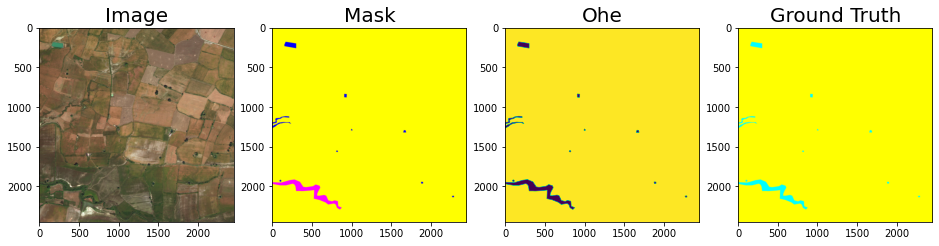

In [11]:
img_Loc = metadata['sat_image_path'][1]
mask_Loc = metadata['mask_path'][1]

img = cv2.imread(img_Loc)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

ohe_mask = reverse_one_hot(cv2.imread(mask_Loc))
# ohe_mask = cv2.cvtColor(ohe_mask, cv2.COLOR_BGR2RGB)

groundTruth = colour_code_segmentation(ohe_mask, select_class_rgb_values)

visualize(Image = img, Mask = mask_Loc, OHE = ohe_mask, ground_truth = groundTruth)

# Data Ingestion and Augmentation
As mentioned above, it is advantageous to use smaller images when modeling. The code below allows us to crop our images and is borrowed and ammended from Jerin Paul. When run, the code iterates through images and corresponding masks in two separate directories, for each image-mask pair, the image and mask are opened, then a cropping filter iterates across each row and column to extract a subset image.

In [12]:
# Indentify the number of satellite images and corresponding masks
numSatImg = len(metadata['sat_image_path'])
numMask = len(metadata['mask_path'])
print("Number of original satellite images: " + str(numSatImg))
print("Number of original masks: " + str(numMask))

# Open example image & mask
img = PIL.Image.open(metadata['sat_image_path'][0])
mask = PIL.Image.open(metadata['mask_path'][0])
# Get dimensionality of that image & mask
numPixels = np.asarray(img).shape
numMaskPx = np.asarray(mask).shape
print('Number of pixels in each image: {}'.format(numPixels))
print('Number of pixels in each masks: {}'.format(numMaskPx))

Number of original satellite images: 803
Number of original masks: 803
Number of pixels in each image: (2448, 2448, 3)
Number of pixels in each masks: (2448, 2448, 3)


In [13]:
# Initialize arrays for cropped sat images and masks
# First we will need to trim the 2448 x 2448 image to 2048 x 2048 image so that it can be used with U-net 
# which needs to have images with sizes divisible by 32
# We will then crop each image down to sections of 128 x 128 x 3, which produces 256 cropped images per original sat image.
# If you want to change the size of the cropped image, change the denominator for cropimg width / height below
# cropImg_height = int((numPixels[0]-400) / 16) # 2048 / 16 = 153
# cropImg_width = int((numPixels[1]-400) / 16) # 2048 / 16 = 153


# X = np.zeros([(numSatImg * 256), cropImg_height, cropImg_width, numPixels[2]], dtype='uint8')
# y = np.zeros([(numMask * 256), cropImg_height, cropImg_width, numPixels[2]], dtype='uint8')
# print('Shape of cropped sat image dataset: {}'.format(X.shape))
# print('Shape of cropped mask dataset: {}'.format(y.shape))

cropImg_height = int((numPixels[0]-400) / 4) # 2048 / 4 = 512
cropImg_width = int((numPixels[1]-400) / 4) # 2048 / 4 = 512

X = np.zeros([(numSatImg * 16), cropImg_height, cropImg_width, numPixels[2]], dtype='uint8')
y = np.zeros([(numMask * 16), cropImg_height, cropImg_width, len(class_dict)], dtype='uint8')
print('Shape of cropped sat image dataset: {}'.format(X.shape))
print('Shape of cropped mask dataset: {}'.format(y.shape))

Shape of cropped sat image dataset: (12848, 512, 512, 3)
Shape of cropped mask dataset: (12848, 512, 512, 7)


In [14]:
# visualize(og_img = img, trimmed = trimm)
# Extract paths from pandas df to np array for iteration purposes - don't want to use iterrows b/c its slow!
Xrows = np.asarray(metadata['sat_image_path'])
yrows = np.asarray(metadata['mask_path'])


# Step 0: Trim images from 2448x2448 to 2048x24048 to make the image size divisible by 32 for Unet purposes
# Step 1: Iterate through image & corresponding mask paths and read images into memory
# Step 2: iterate through original img matrix and crop to predefined crop height & width
# Step 3: Save cropped matrix to working dataset

cropImgIdx = 0

# for i in range(0, len(Xrows)):
for i in range(0, 20):
  
  # Read and normalize image
  img = np.asarray(cv2.imread(Xrows[i]))
  mask = np.asarray(cv2.imread(yrows[i]))
  
  # Trim image to [2048,2048,3] by trimming extra 200px off from the border
  img = np.array(img[200:2248, 200:2248, :])
  mask = np.array(mask[200:2248, 200:2248, :])

  # Iterate through each row
  for r in range(0, img.shape[0], cropImg_height):
    # Iterate through each column
    for c in range(0, img.shape[1], cropImg_width):

      # Slice mask by cropping window first
      # That way we can check if if we're going to use the image or not
      newMask = np.array(mask[r:r+cropImg_height, c:c+cropImg_width, :])
      newMask = cv2.cvtColor(newMask, cv2.COLOR_BGR2RGB)
      
      # Convert mask to grayscale to find distribution of classes
      grayMask = cv2.cvtColor(newMask, cv2.COLOR_BGR2GRAY)
      # Get frequency of each classification in the cropped mask
      unique, frequency = np.unique(grayMask, return_counts= True)
      frequency = frequency / (len(grayMask.flatten()))

      # Check if any classes are represent 99% of image
      # If that is the case, throw it out
      if (frequency >= 0.99).any():
        continue

      # Try one-hot encoding of mask here
      newMask = rgb_to_onehot(newMask, class_dict)

      # Crop image if we make it past the majority class checker
      newImg = np.array(img[r:r+cropImg_height, c:c+cropImg_width, :])
      newImg = cv2.cvtColor(newImg, cv2.COLOR_BGR2RGB)

      X[cropImgIdx,:] = newImg
      y[cropImgIdx,:] = newMask

      cropImgIdx += 1

print('There were {} images cropped from {} original images'.format((cropImgIdx-1), numSatImg))

There were 213 images cropped from 803 original images


In [15]:
cropImgIdx -= 1
X = X[0:cropImgIdx, :,:,:]
y = y[0:cropImgIdx, :,:,:]
print(X.shape)
print(y.shape)

(213, 512, 512, 3)
(213, 512, 512, 7)


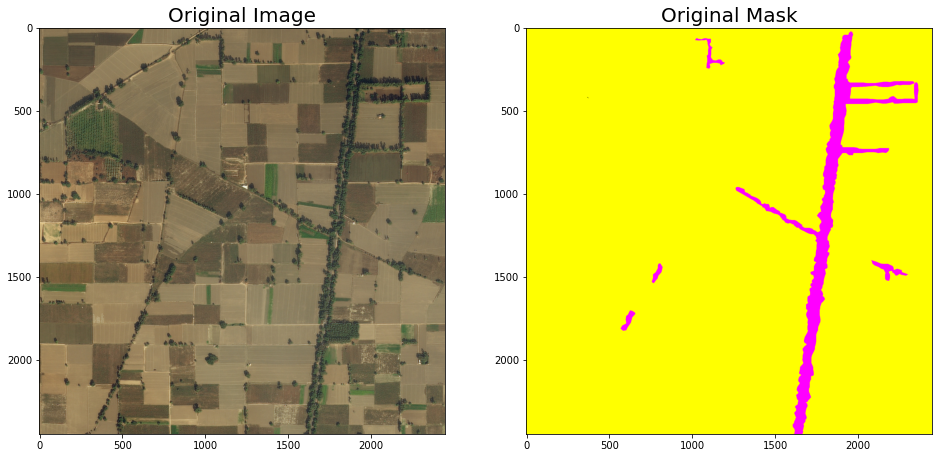

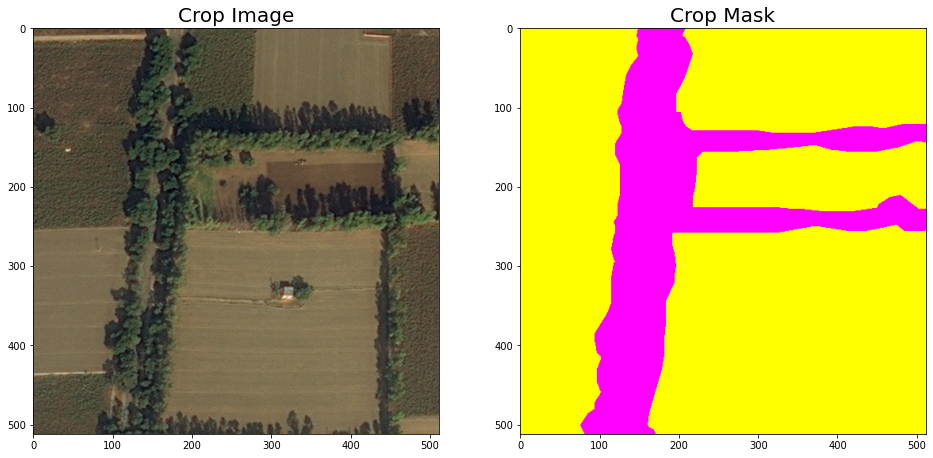

In [16]:
ogImg = Xrows[0]
ogmask = yrows[0]
cropImg = X[0]
cropMsk = onehot_to_rgb(y[0], class_dict)

visualize(original_Image = ogImg, original_Mask = ogmask)
visualize(crop_Image = cropImg, crop_Mask = cropMsk)

# U-Net model building

In [17]:
!pip install keras-unet
!pip install segmentation-models

from keras_unet.models import vanilla_unet, custom_unet
from keras_unet.metrics import iou, iou_thresholded
import segmentation_models as sm

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------
Segmentation Models: using `keras` framework.


In [18]:
## Shuffle DataFrame
## For function origin, check this stack overflow: https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
def unison_shuffled(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X_shuf, y_shuf = unison_shuffled(X, y)

In [19]:
## Downsample so that we don't break our computers
X_down = X_shuf[0:1000, :,:,:]
y_down = y_shuf[0:1000, :,:,:]
print(X_down.shape)
print(y_down.shape)


(213, 512, 512, 3)
(213, 512, 512, 7)


In [62]:
print(X_down.max(), y_down.max())

255 1


In [63]:
print(X_down.shape, y_down.shape)

(213, 512, 512, 3) (213, 512, 512, 7)


In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_down, y_down, test_size=0.42, random_state=42)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (123, 512, 512, 3)
y_train:  (123, 512, 512, 7)
X_test:  (90, 512, 512, 3)
y_test:  (90, 512, 512, 7)


In [67]:
datagen = ImageDataGenerator()

# prepare an iterators to scale images
train_iterator = datagen.flow(X_train, y_train, batch_size=3)
test_iterator = datagen.flow(X_test, y_test, batch_size=3)
print('Batches train=%d, test=%d' % (len(train_iterator), len(test_iterator)))

Batches train=41, test=30


In [68]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

In [69]:
def conv_block(inputs, filters, pool=True):
    x = Conv2D(filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if pool == True:
        p = MaxPool2D((2, 2))(x)
        return x, p
    else:
        return x

In [70]:
def build_unet(shape, num_classes):
    inputs = Input(shape)

    """ Encoder """
    x1, p1 = conv_block(inputs, 16, pool=True)
    x2, p2 = conv_block(p1, 32, pool=True)
    x3, p3 = conv_block(p2, 48, pool=True)
    x4, p4 = conv_block(p3, 64, pool=True)

    """ Bridge """
    b1 = conv_block(p4, 128, pool=False)

    """ Decoder """
    u1 = UpSampling2D((2, 2), interpolation="bilinear")(b1)
    c1 = Concatenate()([u1, x4])
    x5 = conv_block(c1, 64, pool=False)

    u2 = UpSampling2D((2, 2), interpolation="bilinear")(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, 48, pool=False)

    u3 = UpSampling2D((2, 2), interpolation="bilinear")(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, 32, pool=False)

    u4 = UpSampling2D((2, 2), interpolation="bilinear")(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, 16, pool=False)

    """ Output layer """
    output = Conv2D(num_classes, 1, padding="same", activation="softmax")(x8)

    return Model(inputs, output)

if __name__ == "__main__":
    model = build_unet((512, 512, 3), 7)
    model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 512, 512, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 512, 512, 16  64         ['conv2d_19[0][0]']              
 ormalization)                  )                                                           

In [86]:
#hyperparamters
shape = (512, 512, 3)
num_classes = 7
lr = 1e-7
batch_size = 3 # johnathan testing more than 1 image in a batch
epochs = 50 # expanding epochs to see if accuracy improves over time

In [42]:
model = build_unet(shape, num_classes)
model.compile(loss="categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(),  # Johnathan removed lr from Adam parameter because it was keeping lr stagnant, whereas Adam can adjust lr dynamically
              # See: https://www.youtube.com/watch?v=mdKjMPmcWjY
              metrics="accuracy") #Johnathan added accuracy metric morning of 5/2

In [43]:
train_steps = len(X_train)//batch_size
valid_steps = len(X_test)//batch_size

In [46]:
callbacks = [
        ModelCheckpoint("model.unet1", verbose=1, save_best_only = True), # JC changed to only saving best model to save time
        ReduceLROnPlateau(monitor="val_accuracy", patience=5, factor=0.1, verbose=1),
        EarlyStopping(monitor="val_accuracy", patience=10, verbose=1)
    ]

In [47]:
history = model.fit(X_train, y_train,
        steps_per_epoch=train_steps,
        validation_data=(X_test, y_test),
        validation_steps=valid_steps,
        epochs=epochs,
        callbacks=callbacks,
        # verbose=1
    )

Epoch 1/50
41/41 [==============================] - ETA: 0s - loss: 1.4210 - accuracy: 0.4699
Epoch 1: val_loss improved from inf to 1.55330, saving model to model.unet1
INFO:tensorflow:Assets written to: model.unet1/assets
41/41 [==============================] - 11s 279ms/step - loss: 1.4210 - accuracy: 0.4699 - val_loss: 1.5533 - val_accuracy: 0.4693 - lr: 0.0010
Epoch 2/50
41/41 [==============================] - ETA: 0s - loss: 1.3807 - accuracy: 0.4819
Epoch 2: val_loss did not improve from 1.55330
41/41 [==============================] - 4s 106ms/step - loss: 1.3807 - accuracy: 0.4819 - val_loss: 1.5870 - val_accuracy: 0.4693 - lr: 0.0010
Epoch 3/50
41/41 [==============================] - ETA: 0s - loss: 1.3100 - accuracy: 0.5207
Epoch 3: val_loss did not improve from 1.55330
41/41 [==============================] - 4s 106ms/step - loss: 1.3100 - accuracy: 0.5207 - val_loss: 1.7227 - val_accuracy: 0.4672 - lr: 0.0010
Epoch 4/50
41/41 [==============================] - ETA: 0s -

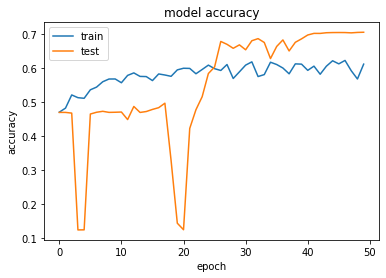

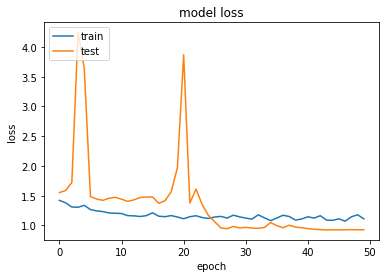

In [48]:

# Johnathan added accuracy and loss plots from HW4

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# import matplotlib
# import matplotlib.pyplot as plt
# plt.plot(history.history['loss'][1:])
# plt.plot(history.history['val_loss'][1:])
# plt.legend(['Training loss', 'Validation loss'])

In [49]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.9269297122955322
Test accuracy: 0.7051502466201782


In [50]:
!pip install keras-tuner

import keras_tuner as kt
from tensorflow import keras
from kerastuner.applications import HyperResNet 
from kerastuner.tuners import Hyperband, RandomSearch, BayesianOptimization
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
# from keras_unet.metrics import iou, iou_thresholded
# from keras_unet.losses import jaccard_distance

In [51]:
def build_model(hp):
  model = build_unet(shape, num_classes)
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-6, 1e-5, 1e-7])
  opt = Adam(learning_rate=hp_learning_rate)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics='accuracy')
  return model

In [52]:
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy', # Johnathan changed from val_loss to val_accuracy 5/2 12:27pm
    max_trials=4, 
    overwrite=True)

In [71]:
tuner.search((train_iterator),
             validation_data=(test_iterator),
             epochs=50)

Trial 4 Complete [00h 00m 47s]
val_accuracy: 0.1517658680677414

Best val_accuracy So Far: 0.3878931999206543
Total elapsed time: 00h 11m 01s
INFO:tensorflow:Oracle triggered exit


In [72]:
n_best_models = tuner.get_best_models(num_models=2)
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [73]:
print(best_hps.values)
print(n_best_models[0].summary())

{'learning_rate': 1e-07}
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                    

In [76]:
tuned_model = tuner.hypermodel.build(best_hps)
tuned_model_history = tuned_model.fit(train_iterator,
                                      validation_data=test_iterator,
                                      epochs=50)


Epoch 1/50
41/41 [==============================] - 7s 118ms/step - loss: 2.2019 - accuracy: 0.1417 - val_loss: 2.2082 - val_accuracy: 0.0738
Epoch 2/50
41/41 [==============================] - 4s 107ms/step - loss: 2.1910 - accuracy: 0.1438 - val_loss: 1.9972 - val_accuracy: 0.2976
Epoch 3/50
41/41 [==============================] - 4s 107ms/step - loss: 2.2050 - accuracy: 0.1483 - val_loss: 1.9624 - val_accuracy: 0.3028
Epoch 4/50
41/41 [==============================] - 4s 107ms/step - loss: 2.1910 - accuracy: 0.1454 - val_loss: 1.9614 - val_accuracy: 0.2627
Epoch 5/50
41/41 [==============================] - 4s 108ms/step - loss: 2.1856 - accuracy: 0.1487 - val_loss: 1.9731 - val_accuracy: 0.2278
Epoch 6/50
41/41 [==============================] - 4s 107ms/step - loss: 2.1905 - accuracy: 0.1483 - val_loss: 1.9930 - val_accuracy: 0.2044
Epoch 7/50
41/41 [==============================] - 4s 107ms/step - loss: 2.1763 - accuracy: 0.1535 - val_loss: 2.0161 - val_accuracy: 0.1905
Epoch 

KeyboardInterrupt: ignored

In [ ]:
y_pred = tuned_model.predict(valid_dataset)

In [ ]:
y_pred.shape

In [ ]:
visualize(satImage = X_test[0],
          groundTruth=(onehot_to_rgb(y_test[0], class_dict)), 
          predicted=(onehot_to_rgb(y_pred[0], class_dict)))

In [88]:
model = build_unet(shape, num_classes)
model.compile(loss="categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(lr),  # Johnathan removed lr from Adam parameter because it was keeping lr stagnant, whereas Adam can adjust lr dynamically
              # See: https://www.youtube.com/watch?v=mdKjMPmcWjY
              metrics="accuracy") #Johnathan added accuracy metric morning of 5/2

In [89]:
train_steps = len(X_train)//batch_size
valid_steps = len(X_test)//batch_size

In [90]:
callbacks = [
        ModelCheckpoint("model.unet1", verbose=1, save_best_only = True), # JC changed to only saving best model to save time
        ReduceLROnPlateau(monitor="val_accuracy", patience=5, factor=0.1, verbose=1),
        EarlyStopping(monitor="val_accuracy", patience=10, verbose=1)
    ]

In [91]:
history = model.fit(X_train, y_train,
        steps_per_epoch=train_steps,
        validation_data=(X_test, y_test),
        validation_steps=valid_steps,
        epochs=epochs,
        callbacks=callbacks,
        # verbose=1
    )

Epoch 1/50
41/41 [==============================] - ETA: 0s - loss: 2.2557 - accuracy: 0.0961
Epoch 1: val_loss improved from inf to 1.98809, saving model to model.unet1
INFO:tensorflow:Assets written to: model.unet1/assets
41/41 [==============================] - 14s 309ms/step - loss: 2.2557 - accuracy: 0.0961 - val_loss: 1.9881 - val_accuracy: 0.0888 - lr: 1.0000e-07
Epoch 2/50
41/41 [==============================] - ETA: 0s - loss: 2.2448 - accuracy: 0.0963
Epoch 2: val_loss did not improve from 1.98809
41/41 [==============================] - 4s 103ms/step - loss: 2.2448 - accuracy: 0.0963 - val_loss: 1.9974 - val_accuracy: 0.1004 - lr: 1.0000e-07
Epoch 3/50
41/41 [==============================] - ETA: 0s - loss: 2.2640 - accuracy: 0.0948
Epoch 3: val_loss did not improve from 1.98809
41/41 [==============================] - 4s 103ms/step - loss: 2.2640 - accuracy: 0.0948 - val_loss: 2.0226 - val_accuracy: 0.1042 - lr: 1.0000e-07
Epoch 4/50
41/41 [==============================]